## 7) Different trajectories / tasks

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from data_utils import get_nth_episode_info
from IPython.display import clear_output
from sapien.core import Pose

from habitat_classes import *

2024-03-08 16:30:44,314 - mani_skill2 - WARNING - Override registered env PickCube-v0
2024-03-08 16:30:44,315 - mani_skill2 - WARNING - Override registered env StackCube-v0
2024-03-08 16:30:44,315 - mani_skill2 - WARNING - Override registered env PickSingleYCB-v0
2024-03-08 16:30:44,316 - mani_skill2 - WARNING - Override registered env PickClutterYCB-v0
2024-03-08 16:30:44,316 - mani_skill2 - WARNING - Override registered env PegInsertionSide-v0
2024-03-08 16:30:44,317 - mani_skill2 - WARNING - Override registered env PlugCharger-v0
2024-03-08 16:30:44,317 - mani_skill2 - WARNING - Override registered env AssemblingKits-v0
2024-03-08 16:30:44,317 - mani_skill2 - WARNING - Override registered env TurnFaucet-v0
2024-03-08 16:30:44,318 - mani_skill2 - WARNING - Override registered env OpenCabinetDoor-v1
2024-03-08 16:30:44,319 - mani_skill2 - WARNING - Override registered env OpenCabinetDrawer-v1
2024-03-08 16:30:44,319 - mani_skill2 - WARNING - Override registered env PushChair-v1
2024-0

# download trajectory from 
# https://huggingface.co/datasets/haosulab/ManiSkill2

In [2]:
from mani_skill2.envs.pick_and_place.base_env import StationaryManipulationEnv
from mani_skill2.utils.registration import register_env
import gymnasium as gym
import sapien.core as sapien
from mani_skill2 import ASSET_DIR
from pathlib import Path
from typing import Dict, List
from mani_skill2 import format_path
from mani_skill2.utils.io_utils import load_json


def build_actor_ycb(
    model_id: str,
    scene: sapien.Scene,
    scale: float = 1.0,
    physical_material: sapien.PhysicalMaterial = None,
    density=1000,
    root_dir=ASSET_DIR / "mani_skill2_ycb",
):
    builder = scene.create_actor_builder()
    model_dir = Path(root_dir) / "models" / model_id

    collision_file = str(model_dir / "collision.obj")
    builder.add_multiple_collisions_from_file(
        filename=collision_file,
        scale=[scale] * 3,
        material=physical_material,
        density=density,
    )

    visual_file = str(model_dir / "textured.obj")
    builder.add_visual_from_file(filename=visual_file, scale=[scale] * 3)

    actor = builder.build()
    return actor


@register_env("CustomEnv-v0", max_episode_steps=200, override=True)
class CustomEnv(StationaryManipulationEnv):
    """
        Customized environment from pick_clutter and single_ycb environment
    """
    DEFAULT_EPISODE_JSON = "{ASSET_DIR}/pick_clutter/ycb_train_5k.json.gz"
    DEFAULT_ASSET_ROOT = "{ASSET_DIR}/mani_skill2_ycb"
    DEFAULT_MODEL_JSON = "info_pick_v0.json"
    
    def __init__(
        self,
        asset_root: str = None,
        model_json: str = None,
        model_ids: List[str] = (),
        obj_init_rot_z=True,
        obj_init_rot=0,
        goal_thresh=0.025,
        **kwargs,
    ):
        if asset_root is None:
            asset_root = self.DEFAULT_ASSET_ROOT
        self.asset_root = Path(format_path(asset_root))

        if model_json is None:
            model_json = self.DEFAULT_MODEL_JSON

        # NOTE(jigu): absolute path will overwrite asset_root
        model_json = self.asset_root / format_path(model_json)
        if not model_json.exists():
            raise FileNotFoundError(
                f"{model_json} is not found."
                "Please download the corresponding assets:"
                "`python -m mani_skill2.utils.download_asset ${ENV_ID}`."
            )
        self.model_db: Dict[str, Dict] = load_json(model_json)

        if isinstance(model_ids, str):
            model_ids = [model_ids]
        if len(model_ids) == 0:
            model_ids = sorted(self.model_db.keys())
        assert len(model_ids) > 0, model_json
        self.model_ids = model_ids

        self.model_scale = None
        self.model_bbox_size = None

        self.obj_init_rot_z = obj_init_rot_z
        self.obj_init_rot = obj_init_rot
        self.goal_thresh = goal_thresh

        self._check_assets()
        super().__init__(**kwargs)

    def _check_assets(self):
        models_dir = self.asset_root / "models"
        for model_id in self.model_ids:
            model_dir = models_dir / model_id
            if not model_dir.exists():
                raise FileNotFoundError(
                    f"{model_dir} is not found."
                    "Please download (ManiSkill2) YCB models:"
                    "`python -m mani_skill2.utils.download_asset ycb`."
                )

            collision_file = model_dir / "collision.obj"
            if not collision_file.exists():
                raise FileNotFoundError(
                    "convex.obj has been renamed to collision.obj. "
                    "Please re-download YCB models."
                )

    # def _initialize_actors(self):
    #     for i in range(len(self.model_ids)):
    #         # Add a small offset to avoid numerical issues for simulation
    #         rs =  np.random.uniform(low=-0.5, high=0.5, size=(2))
    #         self.objs[i].set_pose(Pose(np.array([rs[0], rs[1], 0]) + [0, 0, 0], [1, 0, 0, np.random.randn()]))

    #     # Settle
    #     for _ in range(self.control_freq):
    #         self._scene.step()

    def _initialize_actors(self):
        # Shuffle the list of objects to randomize their order
        shuffled_indices = list(range(len(self.model_ids)))
        np.random.shuffle(shuffled_indices)

        # Determine an area size in which the actors will be placed
        area_size = 0.5  # You might need to adjust this based on your scene size and actor sizes

        for i in shuffled_indices:
            # Randomly choose a position within the area, ensuring there's enough space for the bounding box
            safe_area = 0.4  # Subtract the largest dimension of the bounding box to prevent overlap with the area boundaries
            position = np.random.uniform(low=-0.5 * safe_area, high=0.5 * safe_area, size=(2))

            # Create a random orientation for the actor
            orientation = [1, 0, 0, np.random.randn()]

            # Normalize the orientation quaternion to ensure it's valid
            # orientation = np.array(orientation) / np.linalg.norm(orientation)

            # Set the pose of the actor with the randomized position and orientation
            self.objs[i].set_pose(Pose(np.append(position, 0), orientation))  # Assuming the z-axis is up and actors are placed on a plane

        # Settle
        for _ in range(self.control_freq):
            self._scene.step()

    def _load_actors(self):
        self._add_ground(render=self.bg_name is None)

        self.objs: List[sapien.Actor] = []
        self.bbox_sizes = []
        for model_id in self.model_ids:
            obj = self._load_model(model_id)
            self.objs.append(obj)

            bbox = self.model_db[model_id]["bbox"]
            bbox_size = np.array(bbox["max"]) - np.array(bbox["min"])
            self.bbox_sizes.append(bbox_size)

    def _load_model(self, model_id, model_scale=1.0):
        density = self.model_db[model_id].get("density", 1000)
        obj = build_actor_ycb(
            model_id,
            self._scene,
            scale=model_scale,
            density=density,
            root_dir=self.asset_root,
        )
        obj.name = model_id
        obj.set_damping(0.1, 0.1)

        return obj

    def _get_init_z(self):
        bbox_min = self.model_db[self.model_id]["bbox"]["min"]
        return -bbox_min[2] * self.model_scale + 0.05

    def _register_cameras(self):
        pose = look_at([-1, 0, 1], [0, 0, 0])
        return CameraConfig(
            "base_camera", pose.p, pose.q, 512, 512, np.pi/3, 0.01, 10
        )

In [3]:
env = gym.make("CustomEnv-v0", model_ids=["002_master_chef_can", "003_cracker_box", "004_sugar_box"], obs_mode="rgbd")

[2024-03-08 16:30:44.368] [svulkan2] [error] GLFW error: X11: The DISPLAY environment variable is missing
[2024-03-08 16:30:44.368] [svulkan2] [warning] Continue without GLFW.


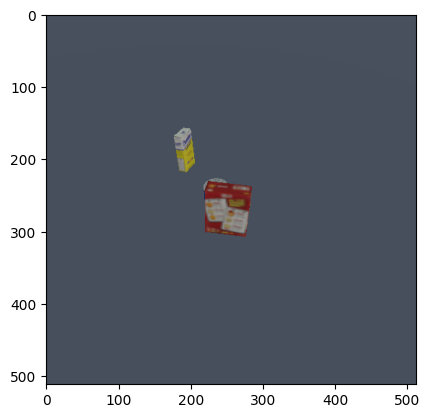

In [4]:
obs, _ = env.reset()
# obs, _ = env.step(env.action_space.sample())
plt.imshow(obs['image']['base_camera']['rgb'])

### Psuedocode for random initialization



One cube
    Move red cube to the right / left / forward / back.
    Bring red cube up / down.

    self._load_cube()

    reset(right / left / forward / back / up / down)





Red cube and Green cube
    Put cube 1 on top / behind / front / right / left of cube 2
Multiple objects
    Move object 1 to the right/left/forward/back/up/down
    Move object 1 behind/front/right/left of object 2




In [5]:
from transforms3d.euler import euler2quat, quat2euler


    
@register_env("CustomEnv-v0", max_episode_steps=200, override=True)
class CustomEnv(PickCubeEnv):
    def _load_actors(self):
        self._add_ground(render=self.bg_name is None)
        self.obj = self._build_cube(self.cube_half_size*4, static=True)
        self.obj2 = self._build_cube(self.cube_half_size*4, color=(0, 0, 1), static=True)
        self.goal_site = self._build_sphere_site(self.goal_thresh)

    def _register_cameras(self):
        pose = look_at([-1, 0, 1], [0, 0, 0])
        return CameraConfig(
            "base_camera", pose.p, pose.q, 1024, 1024, np.pi/3, 0.01, 10
        )

2024-03-08 16:30:45,406 - mani_skill2 - WARNING - Override registered env CustomEnv-v0


In [6]:
env = gym.make("CustomEnv-v0", obs_mode="rgbd")
_ = env.reset()

[2024-03-08 16:30:45.416] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.


In [7]:
def is_overlapping(pos1, pos2, min_dist):
    # Calculate the Euclidean distance between two positions
    dist = np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)
    return dist < min_dist

def generate_non_overlapping_position(existing_positions, min_dist, low=-0.5, high=0.5):
    while True:
        # Generate a random position
        new_position = np.random.uniform(low=low, high=high, size=(2))
        # Check for overlap with existing positions
        overlap = any(is_overlapping(new_position, pos, min_dist) for pos in existing_positions)
        if not overlap:
            return new_position

def initalize_two_cubes(obj1, obj2):
    existing_positions = []
    min_dist = 2 * 4 * np.sqrt(2) * env.cube_half_size[-1]
    position = generate_non_overlapping_position(existing_positions, min_dist)
    obj1.set_pose(Pose([position[0], position[1], env.cube_half_size[-1]*4], euler2quat(0, 0, np.random.uniform(-np.pi*2, np.pi*2))))
    existing_positions.append(position)
    position = generate_non_overlapping_position(existing_positions, min_dist)
    obj2.set_pose(Pose([position[0], position[1], env.cube_half_size[-1]*4], euler2quat(0, 0, np.random.uniform(-np.pi*2, np.pi*2))))

def place_in_direction(env, obj1, obj2, distance, direction):
    pose_obj2 = obj2.get_pose()
    if direction == "front":
        new_position_obj1 = [pose_obj2.p[0] - distance, pose_obj2.p[1], pose_obj2.p[2]]
    elif direction == "behind":
        new_position_obj1 = [pose_obj2.p[0] + distance, pose_obj2.p[1], pose_obj2.p[2]]
    elif direction == "right":
        new_position_obj1 = [pose_obj2.p[0], pose_obj2.p[1] - distance, pose_obj2.p[2]]
    elif direction == "left":
        new_position_obj1 = [pose_obj2.p[0], pose_obj2.p[1] + distance, pose_obj2.p[2]]
    elif direction == "top":
        new_position_obj1 = [pose_obj2.p[0], pose_obj2.p[1], pose_obj2.p[2] + env.cube_half_size[-1]*4*2]
        
    obj1.set_pose(Pose(new_position_obj1, obj1.get_pose().q))

In [8]:
"""
One object
- Move red cube to the right / left / forward / back.

2 objects
- move one object on front / behind / right / left top.

Mutliple objects
- move one object right / left / forward / back.
- move one object on front / behind / right / left top second object.
"""

'\nOne object\n- Move red cube to the right / left / forward / back.\n\n2 objects\n- move one object on front / behind / right / left top.\n\nMutliple objects\n- move one object right / left / forward / back.\n- move one object on front / behind / right / left top second object.\n'

In [9]:
env.get_actors()

/home/mkim/miniconda3/envs/mixlab/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_actors to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_actors` for environment variables or `env.get_wrapper_attr('get_actors')` that will search the reminding wrappers.
  logger.warn(


[Actor(name="ground", id="14"),
 Actor(name="cube", id="15"),
 Actor(name="cube", id="16"),
 Actor(name="goal_site", id="17")]

In [ ]:
from transforms3d.euler import euler2quat, quat2euler

def register_2_object_env(size_1, color_1, size_2, color2):
    @register_env("CustomEnv-v0", max_episode_steps=200, override=True)
    class CustomEnv(PickCubeEnv):
        def _load_actors(self):
            self._add_ground(render=self.bg_name is None)
            self.obj = self._build_cube(self.cube_half_size*4, static=True)
            self.obj2 = self._build_cube(self.cube_half_size*4, color=(0, 0, 1), static=True)
            self.goal_site = self._build_sphere_site(self.goal_thresh)

        def _register_cameras(self):
            pose = look_at([-1, 0, 1], [0, 0, 0])
            return CameraConfig(
                "base_camera", pose.p, pose.q, 1024, 1024, np.pi/3, 0.01, 10
            )

In [9]:
# 2 objects
# - move one object on front / behind / right / left top.

seed = None
obs, _ = env.reset(seed=seed)
np.random.seed(seed)

initalize_two_cubes(env.obj, env.obj2)

fig, axs = plt.subplots(2, 3, figsize=(10, 5))
axs = axs.flatten()
obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
axs[0].imshow(obs['image']['base_camera']['rgb'])
axs[0].set_title("initial")

# for i, direction in enumerate(["front", "behind", "right", "left", "top"]):
#     place_in_direction(env, env.obj, env.obj2, env.cube_half_size[-1]*8*np.sqrt(2), direction)
#     obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
#     axs[i+1].imshow(obs['image']['base_camera']['rgb'])
#     axs[i+1].set_title(direction)

# plt.tight_layout()
# plt.show()

/home/mkim/miniconda3/envs/mixlab/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.obj to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.obj` for environment variables or `env.get_wrapper_attr('obj')` that will search the reminding wrappers.
  logger.warn(
/home/mkim/miniconda3/envs/mixlab/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.obj2 to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.obj2` for environment variables or `env.get_wrapper_attr('obj2')` that will search the reminding wrappers.
  logger.warn(
/home/mkim/miniconda3/envs/mixlab/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.cube_half_size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.cube_half_size` for environme

: 

In [22]:
i = 2
color = (0, 0, 1)

old_obj = getattr(env, f"obj{i}")
pose = old_obj.get_pose()
env.unwrapped._scene.remove_actor(old_obj)
new_obj = env.unwrapped._build_cube(env.cube_half_size*4, color=color, static=True)
new_obj.set_pose(pose)
setattr(env, f"obj{i}", new_obj)

/home/mkim/miniconda3/envs/mixlab/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.cube_half_size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.cube_half_size` for environment variables or `env.get_wrapper_attr('cube_half_size')` that will search the reminding wrappers.
  logger.warn(


In [110]:
quat2euler([1, 0, 0, 1])

(0.0, -0.0, 1.5707963267948966)

In [23]:
from transforms3d.euler import euler2quat, quat2euler

quat2euler(env.obj.get_pose().q)

/home/mkim/miniconda3/envs/mixlab/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.obj to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.obj` for environment variables or `env.get_wrapper_attr('obj')` that will search the reminding wrappers.
  logger.warn(


(0.0007933140169816259, -0.00031126577886030424, -2.4961819343348126)

[2024-03-07 20:46:59.350] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.


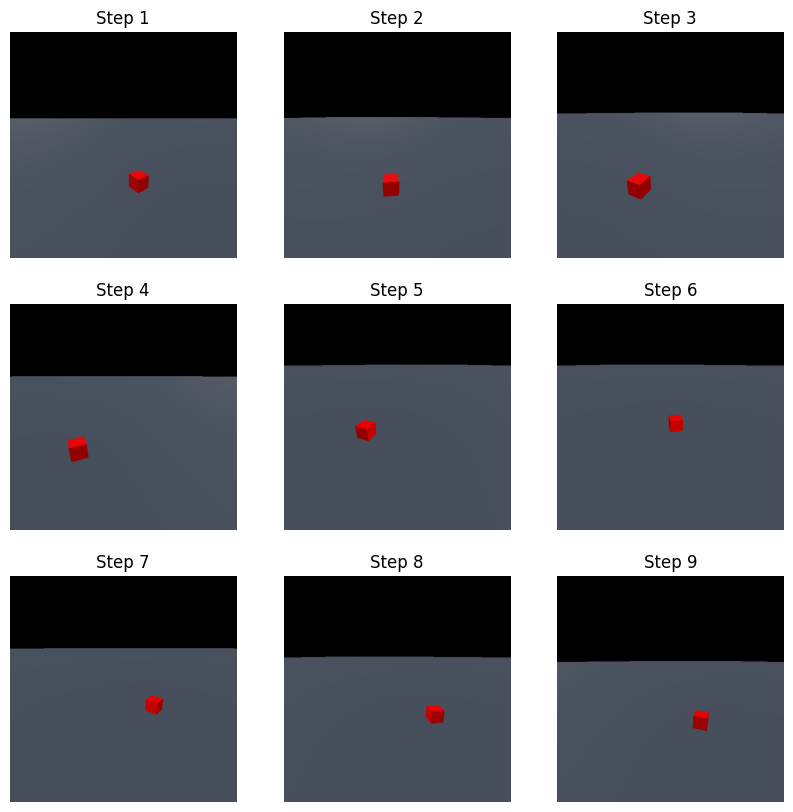

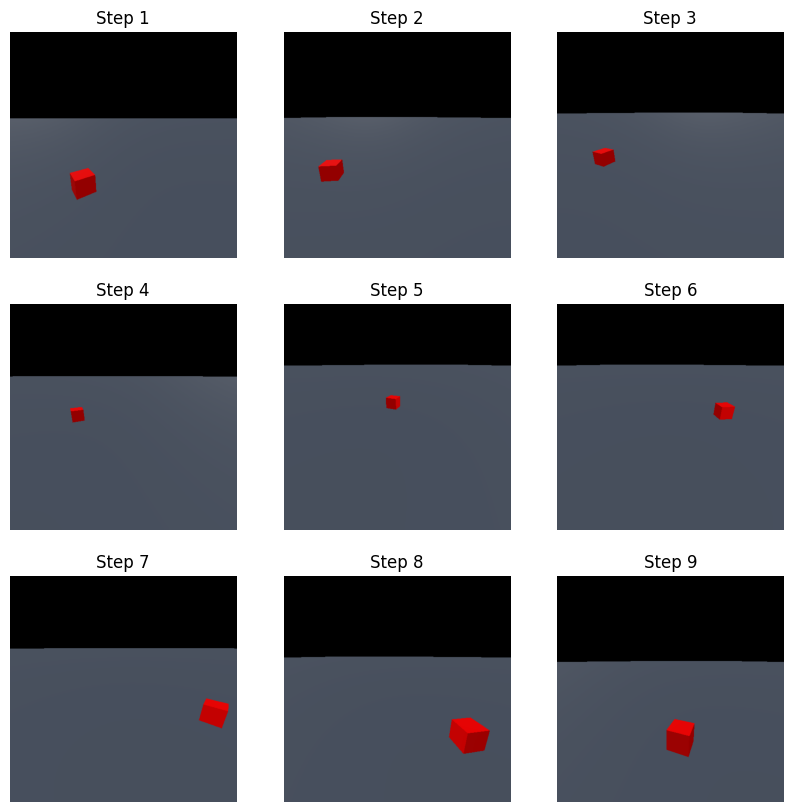

In [17]:
# pick and place
env_info, init_env_state, final_env_state, actions, reset_kwargs, seed = get_nth_episode_info("demos/v0/rigid_body/PickCube-v0/trajectory.h5", 0)
# env_info, init_env_state, final_env_state, actions, reset_kwargs, seed = get_nth_episode_info("demos/v0/rigid_body/StackCube-v0/trajectory.h5", 0)
# env_info, init_env_state, final_env_state, actions, reset_kwargs, seed = get_nth_episode_info("demos/v0/rigid_body/PickSingleYCB-v0/073-e_lego_duplo.h5", 0)
# env_info, init_env_state, final_env_state, actions, reset_kwargs, seed = get_nth_episode_info("demos/v0/rigid_body/PickClutterYCB-v0/trajectory.h5", 1)

# aseembly
# env_info, init_env_state, final_env_state, actions, reset_kwargs, seed = get_nth_episode_info("demos/v0/rigid_body/PegInsertionSide-v0/trajectory.h5", 0)
# env_info, init_env_state, final_env_state, actions, reset_kwargs, seed = get_nth_episode_info("demos/v0/rigid_body/PlugCharger-v0/trajectory.h5", 0)
# env_info, init_env_state, final_env_state, actions, reset_kwargs, seed = get_nth_episode_info("demos/v0/rigid_body/AssemblingKits-v0/trajectory.h5", 0)

# misc
# env_info, init_env_state, final_env_state, actions, reset_kwargs, seed = get_nth_episode_info("demos/v0/rigid_body/TurnFaucet-v0/5002.h5", 0)

# mobile manipulation
# env_info, init_env_state, final_env_state, actions, reset_kwargs, seed = get_nth_episode_info("demos/v0/rigid_body/OpenCabinetDoor-v1/1000/link_1/trajectory.h5", 0)
# env_info, init_env_state, final_env_state, actions, reset_kwargs, seed = get_nth_episode_info("demos/v0/rigid_body/OpenCabinetDrawer-v1/1000/link_1/trajectory.h5", 0)
# env_info, init_env_state, final_env_state, actions, reset_kwargs, seed = get_nth_episode_info("demos/v0/rigid_body/PushChair-v1/3001/trajectory.h5", 0)
# env_info, init_env_state, final_env_state, actions, reset_kwargs, seed = get_nth_episode_info("demos/v0/rigid_body/MoveBucket-v1/4000/trajectory.h5", 0)


# soft body - ignore for now
# env_info, init_env_state, final_env_state, actions, reset_kwargs, seed = get_nth_episode_info("demos/v0/soft_body/Excavate-v0/trajectory.h5", 0)
# for excavate, there is no final state
# env.unwrapped.set_state(env_states)
# plt.imshow(env.unwrapped.render_rgb_array())


# env = gym.make("PickSingleYCB-v0", model_ids="073-e_lego_duplo", **env_info['env_kwargs'])
# env = gym.make("PickSingleYCB-v0", model_ids=["002_master_chef_can", "003_cracker_box"])
env = gym.make(env_info['env_id'], **env_info['env_kwargs'])
obs, _ = env.reset(seed=seed, options=reset_kwargs)
# print(env.obj.name)

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
env.unwrapped.set_state(init_env_state)
obs, reward, terminated, truncated, info = env.step(actions[0])
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(obs["image"][f"camera_{i*3+j}"]["rgb"])
        axs[i, j].set_title(f"Step {i*3+j+1}")
        axs[i, j].axis('off')
plt.show()

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
env.unwrapped.set_state(final_env_state)
obs, reward, terminated, truncated, info = env.step(actions[-1])
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(obs["image"][f"camera_{i*3+j}"]["rgb"])
        axs[i, j].set_title(f"Step {i*3+j+1}")
        axs[i, j].axis('off')
plt.show()


# plt.imshow(env.unwrapped.render_rgb_array())

# # axs[0].imshow(obs["image"]["base_camera"]["rgb"])

# # env.unwrapped.set_state(final_env_state)
# # obs, reward, terminated, truncated, info = env.step(actions[-1])
# axs[1].imshow(obs["image"]["base_camera"]["rgb"])
# axs[1].imshow(env.unwrapped.render_rgb_array())

In [4]:
np.zeros_like(actions[-1])

array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [12]:
env.unwrapped.render_rgb_array().shape

(512, 512, 3)

In [18]:
env.get_state().shape

/home/mkim/miniconda3/envs/mixlab/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_state to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_state` for environment variables or `env.get_wrapper_attr('get_state')` that will search the reminding wrappers.
  logger.warn(


(302981,)

In [ ]:

    # fig, axs = plt.subplots(3, 3)
    # for c in range(9): # 9 cameras
    #     axs[c//3, c%3].imshow(obs["image"][f"camera_{c}"]['rgb'])
    #     axs[c//3, c%3].set_title(f"camera_{c}")

    # fig, axs = plt.subplots(1, 2)

    # plt.imshow(obs["image"]["overhead_camera_0"]['rgb'])
    # axs[0].imshow(env.render_rgb_array())
    # axs[1].imshow(obs["image"]["base_camera"]['rgb'])

    # for push chair
    # fig, axs = plt.subplots(2, 2)
    # plt.imshow(env.unwrapped.render_rgb_array())
    # axs[0, 0].imshow(env.unwrapped.render_rgb_array())
    # axs[0, 1].imshow(obs["image"]["overhead_camera_0"]['rgb'])
    # axs[1, 0].imshow(obs["image"]["overhead_camera_1"]['rgb'])
    # axs[1, 1].imshow(obs["image"]["overhead_camera_2"]['rgb'])


In [ ]:
env.get_actors()

/home/mkim/miniconda3/envs/mixlab/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_actors to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_actors` for environment variables or `env.get_wrapper_attr('get_actors')` that will search the reminding wrappers.
  logger.warn(


[Actor(name="ground", id="14"),
 Actor(name="050_medium_clamp", id="15"),
 Actor(name="goal_site", id="16")]

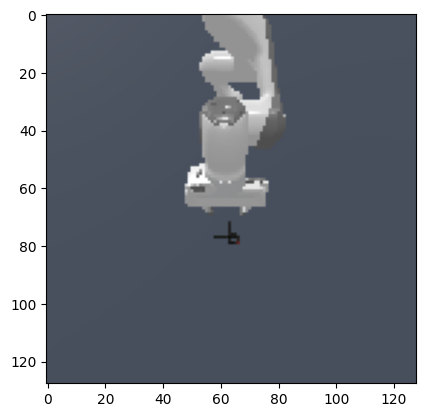

  0%|          | 0/116 [00:00<?, ?it/s]
[2024-03-04 13:38:02.949] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.


KeyboardInterrupt: 

In [ ]:
from glob import glob

for dataset_file in glob("ManiSkill2/demos/v0/rigid_body/PickSingleYCB-v0/PickSingleYCB-v0/*.h5"):
    print(dataset_file)
# dataset_file = "ManiSkill2/demos/v0/rigid_body/PickSingleYCB-v0/PickSingleYCB-v0/058_golf_ball.h5"

    data = h5py.File(dataset_file, "r")
    json_path = dataset_file.replace(".h5", ".json")
    json_data = load_json(json_path)
    episodes = json_data["episodes"]
    env_info = json_data["env_info"]
    env_info["env_kwargs"]["obs_mode"] = 'rgbd'

    for j in range(10):
        eps = episodes[j]
        trajectory = data[f"traj_{eps['episode_id']}"]
        trajectory = load_h5_data(trajectory)

        env_state = trajectory["env_states"][0]
        actions = trajectory['actions']

        env = gym.make(env_info["env_id"], camera_cfgs={"add_segmentation": True}, **env_info["env_kwargs"])
        obs, _ = env.reset()
        env.set_state(env_state)

        for i in tqdm(range(actions.shape[0])):
            obs, reward, terminated, truncated, info = env.step(actions[i])
            clear_output(wait=True)
            # plt.imshow(env.render_rgb_array())
            plt.imshow(obs["image"]["base_camera"]["rgb"])
            plt.show()
            break

In [ ]:
env.get_actors(), env.get_articulations()

([Actor(name="", id="32"),
  Actor(name="visual_ground", id="33"),
  Actor(name="target_indicator", id="34")],
  <sapien.core.pysapien.Articulation at 0x7f9e4af3f870>])

In [ ]:
env_state.shape

(133,)

In [ ]:
env.get_sim_state().shape

actors: 
(13,) ground
(13,) visual_ground
(13,) target_indicator
articulation: 
(57,) mobile_panda_dual_arm
(37,) 3020


/home/mkim/miniconda3/envs/mixlab/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_sim_state to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_sim_state` for environment variables or `env.get_wrapper_attr('get_sim_state')` that will search the reminding wrappers.
  logger.warn(


(133,)